# classification-16

## What's new:

1- https://claude.ai/chat/f3657f31-a334-4ad9-904d-6ca86b00103c

## next step:

1-


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, TimeDistributed, Lambda, RepeatVector, Dropout, \
    BatchNormalization
from tensorflow.keras import Input, layers, models, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, find_peaks, peak_prominences
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-11-24 00:38:52.395973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 00:38:52.523605: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [ ]:
df.shape

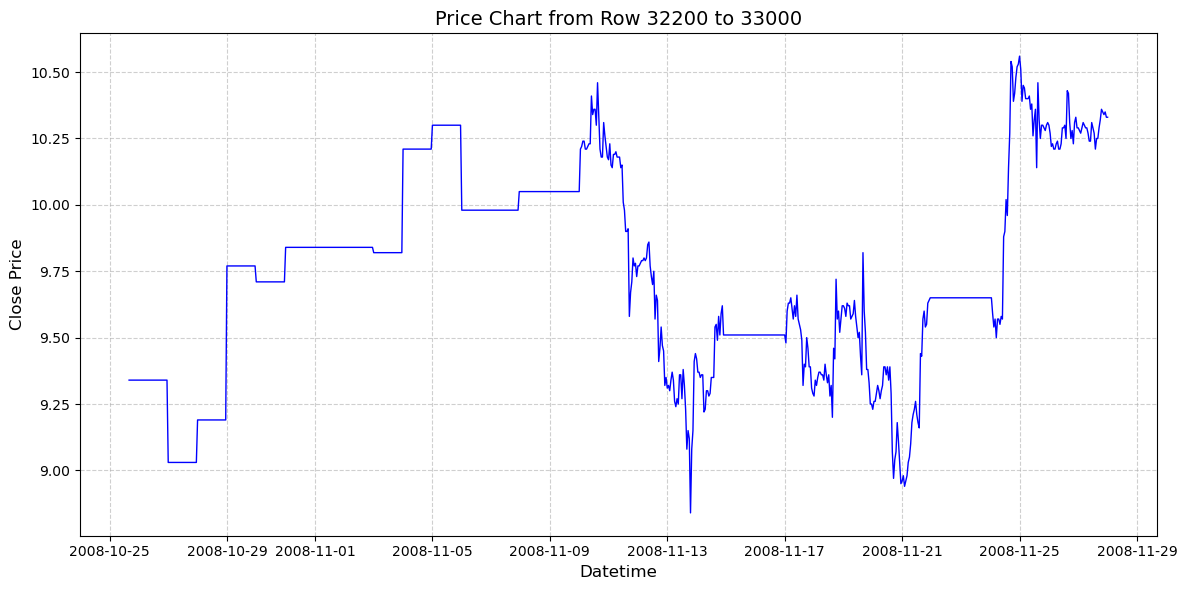

In [3]:
# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [4]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [5]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [6]:
# baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [7]:
# Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")


Label Distribution in df_model:
----------------------------------------
Class 0: 144,229 rows (98.55%)
Class 1: 1,063 rows (0.73%)
Class 2: 1,064 rows (0.73%)
----------------------------------------
Total rows: 146,356


In [8]:
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



In [ ]:
plot_labeled_candles(df_model)

In [9]:
# ============================================================================
# CONSTANTS
# ============================================================================
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
N_FEATURES = len(FEATURES)
N_CLASSES = 3

In [10]:
# ============================================================================
# DATA PREPARATION FUNCTIONS
# ============================================================================

def create_sequences(data, labels, window_size, forecast_horizon):
    """
    Create sequences for multi-step classification.
    Returns X with shape (n_samples, window_size, n_features)
    and y with shape (n_samples, forecast_horizon, n_classes) for multi-label output
    """
    X, y = [], []

    for i in range(len(data) - window_size - forecast_horizon + 1):
        # Input: 60 consecutive candles
        X.append(data[i:i + window_size])

        # Output: next 10 labels (one-hot encoded)
        future_labels = labels[i + window_size:i + window_size + forecast_horizon]
        y.append(future_labels)

    return np.array(X), np.array(y)


def prepare_data(df_model, features=FEATURES):
    """
    Prepare training, validation, and test sets with chronological splitting.
    """
    # Extract features and labels
    feature_data = df_model[features].values
    labels = df_model['Label'].values

    # Normalize features using RobustScaler (better for outliers)
    scaler = RobustScaler()
    feature_data_scaled = scaler.fit_transform(feature_data)

    # Chronological split: 70% train, 15% val, 15% test
    n_total = len(df_model)
    train_end = int(n_total * 0.70)
    val_end = int(n_total * 0.85)

    train_data = feature_data_scaled[:train_end]
    train_labels = labels[:train_end]

    val_data = feature_data_scaled[train_end:val_end]
    val_labels = labels[train_end:val_end]

    test_data = feature_data_scaled[val_end:]
    test_labels = labels[val_end:]

    # Create sequences
    X_train, y_train = create_sequences(train_data, train_labels, WINDOW_SIZE, FORECAST_HORIZON)
    X_val, y_val = create_sequences(val_data, val_labels, WINDOW_SIZE, FORECAST_HORIZON)
    X_test, y_test = create_sequences(test_data, test_labels, WINDOW_SIZE, FORECAST_HORIZON)

    print(f"Training set: {X_train.shape}, {y_train.shape}")
    print(f"Validation set: {X_val.shape}, {y_val.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

In [11]:
# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

def build_reversal_model(window_size=WINDOW_SIZE, n_features=N_FEATURES,
                         forecast_horizon=FORECAST_HORIZON, n_classes=N_CLASSES):
    """
    Build a hybrid CNN-LSTM model for multi-step time series classification.

    Architecture rationale:
    - CNN layers: Extract local patterns in price action
    - LSTM layers: Capture temporal dependencies
    - Attention: Focus on important time steps
    - Multi-output: Predict all 10 steps simultaneously
    """

    inputs = layers.Input(shape=(window_size, n_features))

    # Temporal Convolutional layers for local pattern extraction
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Bidirectional LSTM for temporal dependencies
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer: forecast_horizon * n_classes neurons
    # Reshape to (batch, forecast_horizon, n_classes)
    x = layers.Dense(forecast_horizon * n_classes)(x)
    outputs = layers.Reshape((forecast_horizon, n_classes))(x)
    outputs = layers.Activation('softmax', name='output')(outputs)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [12]:
# ============================================================================
# TRAINING
# ============================================================================

def train_model(X_train, y_train, X_val, y_val, class_weights=None):
    """
    Train the reversal classification model.
    """
    # Build model
    model = build_reversal_model()

    # Calculate class weights for imbalanced data
    # Flatten labels for class weight calculation
    labels_flat = y_train.flatten()
    classes = np.unique(labels_flat)
    weights = compute_class_weight('balanced', classes=classes, y=labels_flat)
    class_weight_dict = {i: weights[i] for i in range(len(weights))}

    print(f"\nClass weights: {class_weight_dict}")

    # Convert y to one-hot encoding for training
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=N_CLASSES)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=N_CLASSES)

    # Compile model with focal loss to handle class imbalance
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',  # For multi-class classification
        metrics=['accuracy']
    )

    print("\nModel Summary:")
    model.summary()

    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )

    # Train model
    history = model.fit(
        X_train, y_train_onehot,
        validation_data=(X_val, y_val_onehot),
        epochs=2,
        batch_size=64,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    return model, history

In [13]:

# ============================================================================
# MODEL SECTION - MAIN TRAINING PIPELINE
# ============================================================================

print("=" * 80)
print("FOREX TREND REVERSAL CLASSIFIER - MODEL TRAINING")
print("=" * 80)

# Prepare data (assuming df_model is already loaded)
print("\n[1/3] Preparing data...")
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data(df_model)

# Train model
print("\n[2/3] Training model...")
model, history = train_model(X_train, y_train, X_val, y_val)

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=N_CLASSES)
test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

print("\n" + "=" * 80)
print("MODEL TRAINING COMPLETE")
print("=" * 80)

FOREX TREND REVERSAL CLASSIFIER - MODEL TRAINING

[1/3] Preparing data...
Training set: (102380, 60, 5), (102380, 10)
Validation set: (21884, 60, 5), (21884, 10)
Test set: (21885, 60, 5), (21885, 10)

[2/3] Training model...

Class weights: {0: np.float64(0.3377506820663559), 1: np.float64(50.93532338308458), 2: np.float64(51.011459890383655)}

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         3,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Activation)             │ (None, 10, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,830 (2.00 MB)

 Trainable params: 523,934 (2.00 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/2
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 129s 78ms/step - accuracy: 0.9822 - loss: 0.1017 - val_accuracy: 0.9816 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 2/2
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 126s 79ms/step - accuracy: 0.9869 - loss: 0.0823 - val_accuracy: 0.9816 - val_loss: 0.1033 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.

[3/3] Evaluating on test set...
Test Loss: 0.0993, Test Accuracy: 0.9826

MODEL TRAINING COMPLETE


In [14]:
# ============================================================================
# PREDICTION SECTION
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTION ON UNSEEN DATA")
print("=" * 80)

given_time = "2025.08.13 21:00:00"
print(f"\nGiven time: {given_time}")

# Find the index of given_time in df (not df_model)
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
given_idx = df[df['DATETIME'] == given_time].index[0]

print(f"Given time index in df: {given_idx}")

# Extract 60 candles ending at given_time
start_idx = given_idx - WINDOW_SIZE + 1
end_idx = given_idx + 1

input_df = df.iloc[start_idx:end_idx][['DATETIME'] + FEATURES].copy()
print(f"Input shape (before scaling): {input_df.shape}")

# Separate DATETIME from features for scaling
input_candles = input_df.copy()  # Keep for visualization (has DATETIME)
input_features_only = input_df[FEATURES].values  # Only features for model

# Scale using the same scaler from training (only the FEATURES columns)
input_scaled = scaler.transform(input_features_only)
input_scaled = input_scaled.reshape(1, WINDOW_SIZE, N_FEATURES)

# Predict
predictions_proba = model.predict(input_scaled, verbose=0)  # Shape: (1, 10, 3)
predictions_proba = predictions_proba[0]  # Shape: (10, 3)

# Get predicted classes
predicted_classes = np.argmax(predictions_proba, axis=1)

# Create forecast datetimes (next 10 hours after given_time)
given_datetime = pd.to_datetime(given_time)
forecast_datetimes = [given_datetime + pd.Timedelta(hours=i + 1) for i in range(FORECAST_HORIZON)]

# Create output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': predicted_classes,
    'prob_0': predictions_proba[:, 0],
    'prob_1': predictions_proba[:, 1],
    'prob_2': predictions_proba[:, 2]
})

print("\n" + "=" * 80)
print("PREDICTION RESULTS")
print("=" * 80)
predicted_df


PREDICTION ON UNSEEN DATA

Given time: 2025.08.13 21:00:00
Given time index in df: 179469
Input shape (before scaling): (60, 6)

PREDICTION RESULTS


,DATETIME,forecast_class,prob_0,prob_1,prob_2
0,2025-08-13 22:00:00,0,0.981789,0.008589,0.009622
1,2025-08-13 23:00:00,0,0.977546,0.011690,0.010764
2,2025-08-14 00:00:00,0,0.982835,0.008450,0.008715
3,2025-08-14 01:00:00,0,0.978944,0.011715,0.009342
4,2025-08-14 02:00:00,0,0.980773,0.011246,0.007981
5,2025-08-14 03:00:00,0,0.977364,0.012063,0.010574
6,2025-08-14 04:00:00,0,0.982440,0.008409,0.009152
7,2025-08-14 05:00:00,0,0.982156,0.009672,0.008173
8,2025-08-14 06:00:00,0,0.976590,0.012263,0.011147
9,2025-08-14 07:00:00,0,0.987392,0.006441,0.006167


# plot section

In [15]:
# --------------------------
# === Visualization Block ===
# --------------------------

historical_df = input_df.tail(4).copy()

In [ ]:
historical_df

In [16]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = given_idx + 1
actual_future_end = given_idx + FORECAST_HORIZON + 1
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()



In [ ]:
actual_future_df

In [17]:
# --- 3. Create predicted_df (forecast for next 10 hours) ---
last_timestamp = pd.to_datetime(df.loc[given_idx, 'DATETIME'])
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)

# --- 4. Add text labels for clarity ---
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



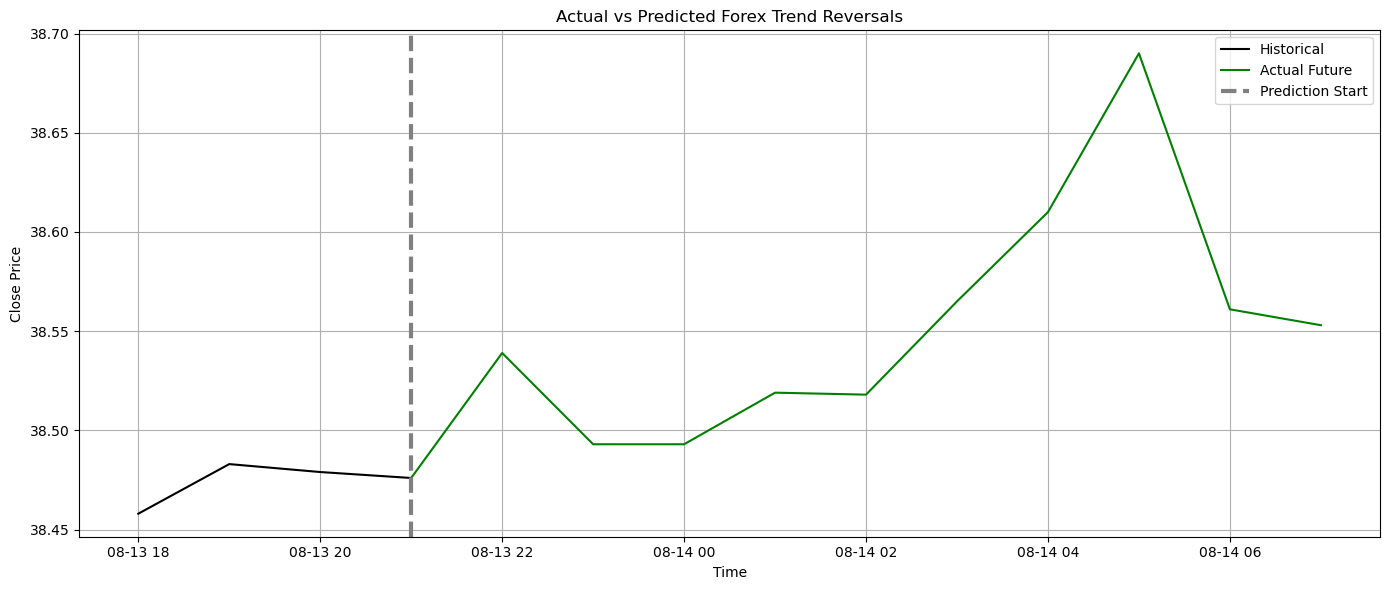

In [18]:
# --- 6. Import your plotting utility ---

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [22]:
# 11- Save Model

from datetime import datetime
import os

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs('saved_models', exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
print(f"\n[SAVING MODEL]")
model.save(model_path)
print(f"Model saved to: {model_path}")

# 11-4 Save scaler (IMPORTANT - needed for predictions!)
import joblib

scaler_path = os.path.join('saved_models', f'scaler_{timestamp}.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 11-5 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)
print(f"Training history saved")

# 11-6 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-7 Save accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_accuracy.png'))
plt.close()

# 11-8 Evaluate on validation set
# model.evaluate returns [loss, accuracy, top2_acc] - 3 values!

# 11-8 Evaluate on validation set
# IMPORTANT: Convert y_val to one-hot encoding for evaluation
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=N_CLASSES)
eval_results = model.evaluate(X_val, y_val_onehot, verbose=0)

final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = eval_results[0]
final_val_acc = eval_results[1]

# 11-9 Save model summary and performance metrics
summary_path = os.path.join(log_dir, 'model_log.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('\n')
    f.write(f'Final Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Training Accuracy: {final_train_acc:.6f}\n')
    f.write(f'Final Validation Loss: {final_val_loss:.6f}\n')
    f.write(f'Final Validation Accuracy: {final_val_acc:.6f}\n')

print(f"Model summary and metrics saved to: {summary_path}")
print(f"\n[SAVE COMPLETE]")
print(f"All files saved in: saved_models/")


[SAVING MODEL]
Model saved to: saved_models/model_20251124_005638.keras
Scaler saved to: saved_models/scaler_20251124_005638.pkl
Training history saved


Model summary and metrics saved to: saved_models/model_20251124_005638_logs/model_log.txt

[SAVE COMPLETE]
All files saved in: saved_models/


In [ ]:
model_path = 'saved_models/model_20251116_190307.keras'
model = keras.models.load_model(
    model_path,
    safe_mode=False
)